# Hyperparameters select

## Library

In [7]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers, losses, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from pathlib import Path    # for saving purpose

## Setup

In [9]:
train_dir = './dataset/train'
val_dir = './dataset/val'
# Not used for training
test_dir = './dataset/test'

ckpt_dir = './checkpoint/'

BATCH_SIZE = 256
IMG_SIZE = (256, 256)
IMG_SHAPE = IMG_SIZE + (3,)
N_CLASSES = 40

INITIAL_EPOCHS = 20
FINE_TUNE_EPOCHS = 20
total_epochs =  INITIAL_EPOCHS + FINE_TUNE_EPOCHS

## Load Dataset

In [3]:
train_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()

train_dataset = train_gen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,class_mode='sparse')
val_dataset = val_gen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='sparse')

Found 16629 images belonging to 40 classes.
Found 2771 images belonging to 40 classes.


## Import model and add FC layers

In [4]:
def food_model(dropout_rate=0.2):
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
    base_model.trainable = False

    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(320)(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(N_CLASSES)(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [5]:
model = food_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_truediv (TensorF [(None, 256, 256, 3)]     0         
_________________________________________________________________
tf_op_layer_sub (TensorFlowO [(None, 256, 256, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 320)               409920

In [6]:
def TF_plot_graph(lr_list, histories, opt_type=None):
    plt.figure(figsize=(8, 12))
    for lr, history in zip(lr_list, histories):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        for i in range(15, 20):
            print('lr: ', lr, ' epoch: ', i+1, ' train acc: ', acc[i], ' val acc: ', val_acc[i])
        print()

        plt.subplot(4, 1, 1)
        plt.plot(acc, label=('lr: %.4g\'s Training Acc') % (lr))
        plt.ylim([0.4, 1])
        plt.legend(loc='lower right')

        plt.subplot(4, 1, 2)
        plt.plot(val_acc, label=('lr: %.4g\'s Val Acc') % (lr))
        plt.ylim([0.4, 1])
        plt.legend(loc='lower right')

        plt.subplot(4, 1, 3)
        plt.plot(loss, label=('lr: %.4g\'s Training Loss') % (lr))
        plt.ylim([0, 1])
        plt.legend(loc='upper right')

        plt.subplot(4, 1, 4)
        plt.plot(val_loss, label=('lr: %.4g\'s Val Loss') % (lr))
        plt.ylim([0, 1])
        plt.legend(loc='upper right')

        plt.xlabel('epoch')
    if opt_type:
        plt.savefig('./Result/' + opt_type + '_TF_comparasion.png', dpi=300)
    plt.show()

## Test SGD with different hyperparameters

In [10]:
lr_list = [0.05, 0.01, 0.005, 0.001]
loss_function = losses.SparseCategoricalCrossentropy(from_logits=True)
sgd_histories = []

for lr in lr_list:
    model_name = 'LR' + str(lr) + '_TF_SGDM_02Dp_20epo'

    sgdm_opt = optimizers.SGD(learning_rate = lr, momentum=0.9)
    model = food_model(dropout_rate=0.2)
    model.compile(optimizer=sgdm_opt, loss=loss_function, metrics=['accuracy'])
    cp_callback = callbacks.ModelCheckpoint(filepath=ckpt_dir+model_name+'.ckpt', save_weights_only=True, save_best_only=True)

    history = model.fit(train_dataset, epochs = INITIAL_EPOCHS, verbose = 2, validation_data = val_dataset, callbacks=[cp_callback])

    sgd_histories.append(history)
    model.save('./model/' + model_name + '.h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 65 steps, validate for 11 steps
Epoch 1/20
65/65 - 41s - loss: 1.7320 - accuracy: 0.5208 - val_loss: 0.9240 - val_accuracy: 0.7218
Epoch 2/20
65/65 - 32s - loss: 0.9468 - accuracy: 0.7149 - val_loss: 0.8129 - val_accuracy: 0.7593
Epoch 3/20
65/65 - 32s - loss: 0.8392 - accuracy: 0.7442 - val_loss: 0.7660 - val_accuracy: 0.7672
Epoch 4/20
65/65 - 32s - loss: 0.7552 - accuracy: 0.7641 - val_loss: 0.7226 - val_accuracy: 0.7813
Epoch 5/20
65/65 - 31s - loss: 0.7023 - accuracy: 0.7822 - val_loss: 0.7173 - val_accuracy: 0.7806
Epoch 6/20
65/65 - 30s - loss: 0.6569 - accuracy: 0.7952 - val_loss: 0.6825 - val_accuracy: 0.7994
Epoch 7/20
65/65 - 31s - loss: 0.6138 - accuracy: 0.8048 - val_loss: 0.6780 - val_accuracy: 0.7943
Epoch 8/20
65/65 - 30s - loss: 0.5709 - accuracy: 0.8182 - val_loss: 0.6803 - val_accuracy: 0.7968
Epoch 9/20
65/65 - 31s - loss: 0.5474 - accuracy: 0.8277 - val_loss: 0.6650 - val_accuracy: 0.8004
Epoch 10/20
65/65

lr:  0.05  epoch:  16  train acc:  0.8669192  val acc:  0.80223745
lr:  0.05  epoch:  17  train acc:  0.8758193  val acc:  0.8051245
lr:  0.05  epoch:  18  train acc:  0.87413555  val acc:  0.8087333
lr:  0.05  epoch:  19  train acc:  0.8803897  val acc:  0.80404186
lr:  0.05  epoch:  20  train acc:  0.8863431  val acc:  0.8062071

lr:  0.01  epoch:  16  train acc:  0.80666304  val acc:  0.79935044
lr:  0.01  epoch:  17  train acc:  0.8076854  val acc:  0.797546
lr:  0.01  epoch:  18  train acc:  0.8109327  val acc:  0.7971851
lr:  0.01  epoch:  19  train acc:  0.81682605  val acc:  0.8011548
lr:  0.01  epoch:  20  train acc:  0.81652534  val acc:  0.8011548

lr:  0.005  epoch:  16  train acc:  0.769018  val acc:  0.7827499
lr:  0.005  epoch:  17  train acc:  0.7740093  val acc:  0.78058463
lr:  0.005  epoch:  18  train acc:  0.77743703  val acc:  0.7827499
lr:  0.005  epoch:  19  train acc:  0.7823681  val acc:  0.78563696
lr:  0.005  epoch:  20  train acc:  0.78405195  val acc:  0.79

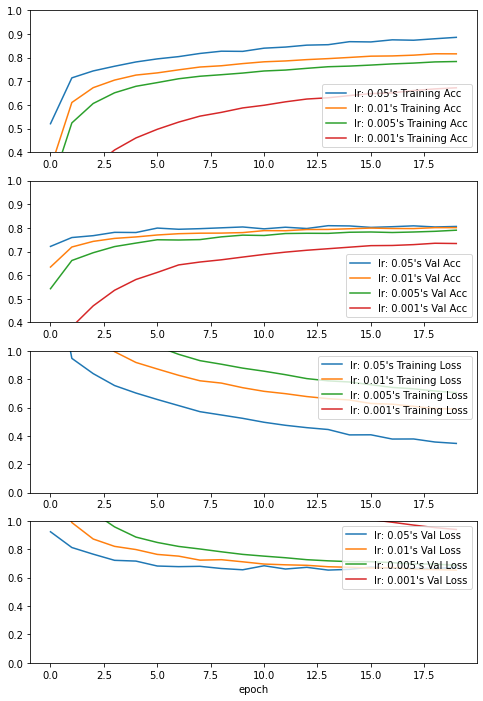

In [14]:
TF_plot_graph(lr_list, sgd_histories, 'SGDM_02Dp')

## Test ADAM with different hyperparameters

In [20]:
lr_list = [0.005, 0.001, 0.0005, 0.0001]
loss_function = losses.SparseCategoricalCrossentropy(from_logits=True)
adam_histories = []

for lr in lr_list:
    adam_opt = optimizers.Adam(learning_rate = lr)
    model = food_model()
    model.compile(optimizer=adam_opt, loss=loss_function, metrics=['accuracy'])
    history = model.fit(train_dataset, epochs = INITIAL_EPOCHS, verbose = 2, validation_data = val_dataset)
    adam_histories.append(history)
    model.save('./model/LR' + str(lr) + '_TF_ADAM_02Dp_20epo.h5')


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 65 steps, validate for 11 steps
Epoch 1/20
65/65 - 35s - loss: 72.2085 - accuracy: 0.4350 - val_loss: 22.4063 - val_accuracy: 0.6546
Epoch 2/20
65/65 - 31s - loss: 19.2487 - accuracy: 0.6561 - val_loss: 12.6550 - val_accuracy: 0.7174
Epoch 3/20
65/65 - 31s - loss: 11.6884 - accuracy: 0.6940 - val_loss: 10.5071 - val_accuracy: 0.7106
Epoch 4/20
65/65 - 31s - loss: 8.9913 - accuracy: 0.7049 - val_loss: 9.2466 - val_accuracy: 0.7102
Epoch 5/20
65/65 - 30s - loss: 8.2780 - accuracy: 0.7079 - val_loss: 8.7295 - val_accuracy: 0.7167
Epoch 6/20
65/65 - 30s - loss: 8.0210 - accuracy: 0.7129 - val_loss: 9.7288 - val_accuracy: 0.6904
Epoch 7/20
65/65 - 30s - loss: 9.1355 - accuracy: 0.7033 - val_loss: 11.3962 - val_accuracy: 0.6871
Epoch 8/20
65/65 - 30s - loss: 11.5172 - accuracy: 0.7023 - val_loss: 15.7897 - val_accuracy: 0.6601
Epoch 9/20
65/65 - 30s - loss: 15.2940 - accuracy: 0.6924 - val_loss: 17.5792 - val_accuracy: 0.6951
Epoch 

lr:  0.05  epoch:  16  train acc:  0.72024775  val acc:  0.72284377
lr:  0.05  epoch:  17  train acc:  0.7387095  val acc:  0.7260917
lr:  0.05  epoch:  18  train acc:  0.7425582  val acc:  0.72248286
lr:  0.05  epoch:  19  train acc:  0.74520415  val acc:  0.7369181
lr:  0.05  epoch:  20  train acc:  0.7492934  val acc:  0.72248286

lr:  0.01  epoch:  16  train acc:  0.75542724  val acc:  0.72067845
lr:  0.01  epoch:  17  train acc:  0.7528414  val acc:  0.73150486
lr:  0.01  epoch:  18  train acc:  0.7644476  val acc:  0.72861785
lr:  0.01  epoch:  19  train acc:  0.7631848  val acc:  0.740166
lr:  0.01  epoch:  20  train acc:  0.7672139  val acc:  0.7365572

lr:  0.005  epoch:  16  train acc:  0.81502193  val acc:  0.7531577
lr:  0.005  epoch:  17  train acc:  0.8212159  val acc:  0.7589318
lr:  0.005  epoch:  18  train acc:  0.8149618  val acc:  0.75929266
lr:  0.005  epoch:  19  train acc:  0.811053  val acc:  0.7571274
lr:  0.005  epoch:  20  train acc:  0.8177882  val acc:  0.75

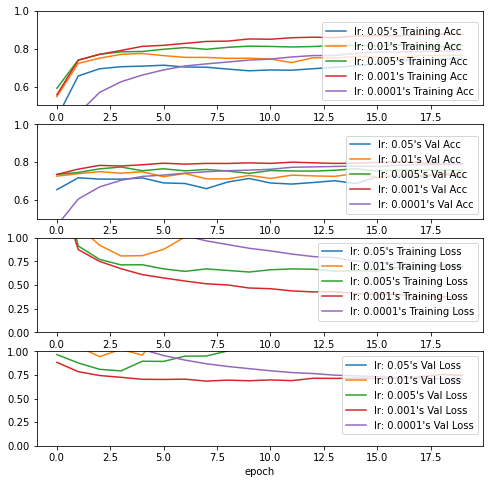

In [27]:
TF_plot_graph(lr_list, adam_histories, 'ADAM_02Dp')

## Test SGDM with 0.4 dropout rate

In [15]:
lr_list = [0.05, 0.01, 0.005, 0.001]
loss_function = losses.SparseCategoricalCrossentropy(from_logits=True)
sgd_histories = []

for lr in lr_list:
    model_name = 'LR' + str(lr) + '_TF_SGDM_04Dp_20epo'

    sgdm_opt = optimizers.SGD(learning_rate = lr, momentum=0.9)
    model = food_model(dropout_rate=0.4)
    model.compile(optimizer=sgdm_opt, loss=loss_function, metrics=['accuracy'])
    cp_callback = callbacks.ModelCheckpoint(filepath=ckpt_dir+model_name+'.ckpt', save_weights_only=True, save_best_only=True)

    history = model.fit(train_dataset, epochs = INITIAL_EPOCHS, verbose = 2, validation_data = val_dataset, callbacks=[cp_callback])

    sgd_histories.append(history)
    model.save('./model/' + model_name + '.h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 65 steps, validate for 11 steps
Epoch 1/20
65/65 - 34s - loss: 2.0479 - accuracy: 0.4416 - val_loss: 1.0428 - val_accuracy: 0.6997
Epoch 2/20
65/65 - 31s - loss: 1.2341 - accuracy: 0.6299 - val_loss: 0.9131 - val_accuracy: 0.7340
Epoch 3/20
65/65 - 32s - loss: 1.1084 - accuracy: 0.6699 - val_loss: 0.8364 - val_accuracy: 0.7560
Epoch 4/20
65/65 - 31s - loss: 1.0377 - accuracy: 0.6851 - val_loss: 0.8127 - val_accuracy: 0.7607
Epoch 5/20
65/65 - 31s - loss: 0.9712 - accuracy: 0.7000 - val_loss: 0.7675 - val_accuracy: 0.7694
Epoch 6/20
65/65 - 31s - loss: 0.9415 - accuracy: 0.7124 - val_loss: 0.7519 - val_accuracy: 0.7781
Epoch 7/20
65/65 - 31s - loss: 0.9032 - accuracy: 0.7222 - val_loss: 0.7571 - val_accuracy: 0.7806
Epoch 8/20
65/65 - 31s - loss: 0.8815 - accuracy: 0.7268 - val_loss: 0.7393 - val_accuracy: 0.7744
Epoch 9/20
65/65 - 31s - loss: 0.8501 - accuracy: 0.7350 - val_loss: 0.7168 - val_accuracy: 0.7838
Epoch 10/20
65/65

lr:  0.05  epoch:  16  train acc:  0.76462805  val acc:  0.7971851
lr:  0.05  epoch:  17  train acc:  0.7706416  val acc:  0.8015157
lr:  0.05  epoch:  18  train acc:  0.7753924  val acc:  0.7957416
lr:  0.05  epoch:  19  train acc:  0.77262616  val acc:  0.7986286
lr:  0.05  epoch:  20  train acc:  0.77515185  val acc:  0.8076507

lr:  0.01  epoch:  16  train acc:  0.72620124  val acc:  0.7831108
lr:  0.01  epoch:  17  train acc:  0.73047084  val acc:  0.7845543
lr:  0.01  epoch:  18  train acc:  0.7366649  val acc:  0.788524
lr:  0.01  epoch:  19  train acc:  0.73335737  val acc:  0.7924937
lr:  0.01  epoch:  20  train acc:  0.741596  val acc:  0.7888849

lr:  0.005  epoch:  16  train acc:  0.6922846  val acc:  0.76687115
lr:  0.005  epoch:  17  train acc:  0.7006435  val acc:  0.7773367
lr:  0.005  epoch:  18  train acc:  0.7056347  val acc:  0.7773367
lr:  0.005  epoch:  19  train acc:  0.7035901  val acc:  0.77769756
lr:  0.005  epoch:  20  train acc:  0.7114679  val acc:  0.77408

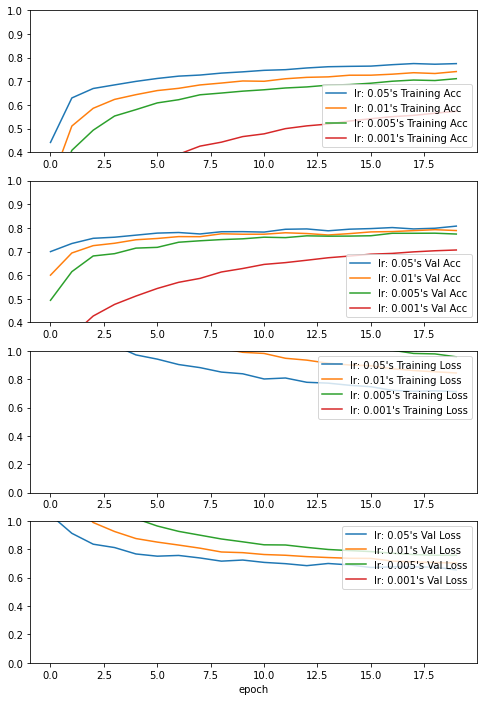

In [16]:
TF_plot_graph(lr_list, sgd_histories, 'SGDM_04Dp')

## Test Adam with 0.4 dropout rate

In [18]:
lr_list = [0.005, 0.001, 0.0001]
loss_function = losses.SparseCategoricalCrossentropy(from_logits=True)
adam_histories = []

for lr in lr_list:
    model_name = 'LR' + str(lr) + '_TF_ADAM_04Dp_20epo'

    adam_opt = optimizers.Adam(learning_rate = lr)
    model = food_model(dropout_rate=0.4)
    model.compile(optimizer=adam_opt, loss=loss_function, metrics=['accuracy'])
    cp_callback = callbacks.ModelCheckpoint(filepath=ckpt_dir+model_name+'.ckpt', save_weights_only=True, save_best_only=True)

    history = model.fit(train_dataset, epochs = INITIAL_EPOCHS, verbose = 2, validation_data = val_dataset, callbacks=[cp_callback])

    adam_histories.append(history)
    model.save('./model/' + model_name + '.h5')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 65 steps, validate for 11 steps
Epoch 1/20
65/65 - 34s - loss: 1.6857 - accuracy: 0.5268 - val_loss: 0.8823 - val_accuracy: 0.7340
Epoch 2/20
65/65 - 31s - loss: 1.0839 - accuracy: 0.6776 - val_loss: 0.8189 - val_accuracy: 0.7560
Epoch 3/20
65/65 - 31s - loss: 0.9953 - accuracy: 0.7005 - val_loss: 0.7665 - val_accuracy: 0.7698
Epoch 4/20
65/65 - 32s - loss: 0.9305 - accuracy: 0.7154 - val_loss: 0.7609 - val_accuracy: 0.7643
Epoch 5/20
65/65 - 33s - loss: 0.8925 - accuracy: 0.7255 - val_loss: 0.7447 - val_accuracy: 0.7726
Epoch 6/20
65/65 - 32s - loss: 0.8850 - accuracy: 0.7305 - val_loss: 0.7453 - val_accuracy: 0.7755
Epoch 7/20
65/65 - 32s - loss: 0.8658 - accuracy: 0.7383 - val_loss: 0.7461 - val_accuracy: 0.7759
Epoch 8/20
65/65 - 32s - loss: 0.8404 - accuracy: 0.7462 - val_loss: 0.7134 - val_accuracy: 0.7781
Epoch 9/20
65/65 - 32s - loss: 0.8284 - accuracy: 0.7447 - val_loss: 0.7136 - val_accuracy: 0.7752
Epoch 10/20
65/65

lr:  0.005  epoch:  16  train acc:  0.7691383  val acc:  0.77444965
lr:  0.005  epoch:  17  train acc:  0.76625174  val acc:  0.7878022
lr:  0.005  epoch:  18  train acc:  0.7678153  val acc:  0.77661496
lr:  0.005  epoch:  19  train acc:  0.77364844  val acc:  0.77481055
lr:  0.005  epoch:  20  train acc:  0.7715437  val acc:  0.77805847

lr:  0.001  epoch:  16  train acc:  0.80076975  val acc:  0.8015157
lr:  0.001  epoch:  17  train acc:  0.8078658  val acc:  0.80223745
lr:  0.001  epoch:  18  train acc:  0.8067232  val acc:  0.80259836
lr:  0.001  epoch:  19  train acc:  0.8114138  val acc:  0.80368096
lr:  0.001  epoch:  20  train acc:  0.8150821  val acc:  0.80548537

lr:  0.0001  epoch:  16  train acc:  0.6653437  val acc:  0.76073617
lr:  0.0001  epoch:  17  train acc:  0.67081606  val acc:  0.7679538
lr:  0.0001  epoch:  18  train acc:  0.6771904  val acc:  0.76362324
lr:  0.0001  epoch:  19  train acc:  0.68206143  val acc:  0.76723206
lr:  0.0001  epoch:  20  train acc:  0.6

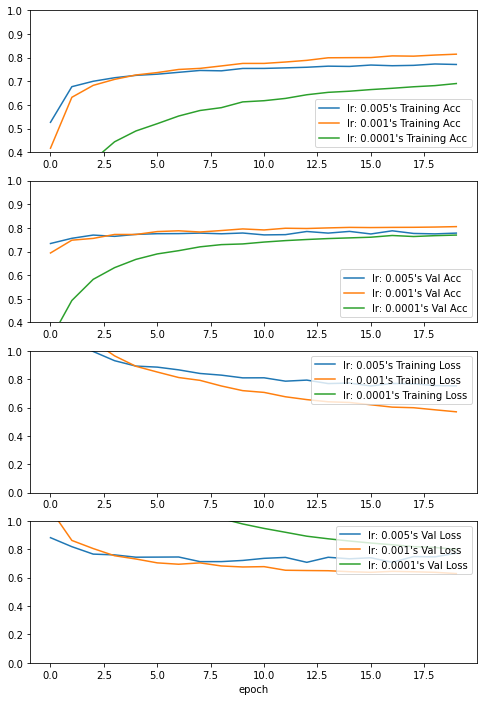

In [20]:
TF_plot_graph(lr_list, adam_histories, 'ADAM_04Dp')

## Final results: 
SGDM choose 0.05 and 0.01, fine tune both 0.2 and 0.4 drop.<br>
ADAM choose 0.001, fine tune 0.4 drop.